# Decoupled Feature-Temporal CNN: Explaining Deep Learning-based Machine Health Monitoring



### Load the extracted features

In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import h5py
h5f = h5py.File("/content/drive/My Drive/data/data_cwru/datax_series.h5", "r")
print(h5f.keys())
features = h5f.get("data")
import numpy as np
features = np.array(features)
h5f.close()

<KeysViewHDF5 ['data']>


In [ ]:
features.shape

(14368, 20, 1, 9)

In [ ]:
h5f = h5py.File("/content/drive/My Drive/data/data_cwru/datay_series.h5", "r")
print(h5f.keys())
labels = h5f.get("label")
labels = np.array(labels)
h5f.close()

<KeysViewHDF5 ['label']>


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_trainonehot, y_testonehot = train_test_split(features, labels, test_size=0.2, random_state=1)
scaler = StandardScaler()

In [ ]:
#data dimension, time steps, number of sensors, feature dimensions
shape1, shape2, shape3, shape4 = X_train.shape
#reshape the data into a matrix format
raw_data = X_train.reshape(shape1*shape2, shape3*shape4)
#normalize the data
new_data = scaler.fit_transform(raw_data)
X_trainnew = new_data.reshape(shape1, shape2, shape4, shape3)
print(X_trainnew.shape)

(11494, 20, 9, 1)


In [ ]:
#normalize the testing data
shape1, shape2, shape3, shape4 = X_test.shape
raw_data = X_test.reshape(shape1*shape2, shape3*shape4)
new_data = scaler.transform(raw_data)
X_testnew = new_data.reshape(shape1, shape2, shape4,shape3)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pylab 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## visualize the original data

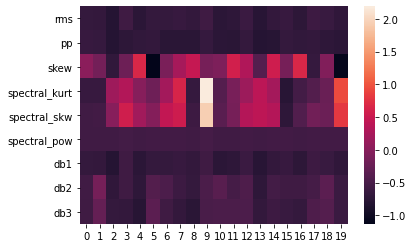

In [ ]:
yticks = ["rms","pp","skew", 
         "spectral_kurt", "spectral_skw", "spectral_pow",
         "db1", "db2", "db3"]
ax = sns.heatmap(X_trainnew[0,:,:,0].T,yticklabels=yticks)
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers 
import random
import pandas as pd
import numpy as np
import os

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

#Try to control the random seed
reset_random_seeds()


In [ ]:
#build keras time series model
from keras.layers import Conv1D, Dense, Dropout, Input, Conv3D,Conv2D, Flatten, Lambda
from keras.models import Model
import keras.backend as K
import cv2
y_train = to_categorical(y_trainonehot)
y_test = to_categorical(y_testonehot)

### Build the DeftCNN architecture.

The structure is fully described here.


In [ ]:
squeeze=Lambda(lambda x: K.squeeze(x, axis=-1) )
shapes = (20,9,1)
input_seq = Input(shape=shapes)
#2D Convolution Layer: Feature Saliency
y = Conv2D(32, (5,1), strides=(1,1), activation='relu',input_shape=shapes, name='feaconv')(input_seq)
y = Dropout(0.5)(y)
#Network In Network
y2 = Conv2D(1, (1,1), activation='relu', name='nin')(y)
y2 = Dropout(0.5)(y2)
y2 = squeeze(y2)
#1D Convolutional Layer: Time Saliency
y3 = Conv1D(32, (3), activation='relu', name='timeconv')(y2)
#Fully-Connected Layer
y4 = Flatten()(y3)
y4 = Dense(64, activation="relu")(y4)
output_label = Dense(4, activation="softmax")(y4)
model = Model(inputs=input_seq, outputs=output_label)

(None, 16, 9, 1)
(None, 16, 9)
(None, 14, 32)


In [ ]:
# check the model structure
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 9, 1)]        0         
_________________________________________________________________
feaconv (Conv2D)             (None, 16, 9, 32)         192       
_________________________________________________________________
dropout (Dropout)            (None, 16, 9, 32)         0         
_________________________________________________________________
nin (Conv2D)                 (None, 16, 9, 1)          33        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 9, 1)          0         
_________________________________________________________________
lambda (Lambda)              (None, 16, 9)             0         
_________________________________________________________________
timeconv (Conv1D)            (None, 14, 32)           

In [ ]:
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_trainnew, y_train, validation_data=(X_testnew, y_test), epochs=40, batch_size=128)

Epoch 1/40
90/90 [==============================] - 2s 23ms/step - loss: 1.3913 - accuracy: 0.2482 - val_loss: 1.3536 - val_accuracy: 0.3702
Epoch 2/40
90/90 [==============================] - 2s 21ms/step - loss: 1.3285 - accuracy: 0.3638 - val_loss: 1.2605 - val_accuracy: 0.5177
Epoch 3/40
90/90 [==============================] - 2s 21ms/step - loss: 1.1975 - accuracy: 0.4857 - val_loss: 1.0600 - val_accuracy: 0.5080
Epoch 4/40
90/90 [==============================] - 2s 21ms/step - loss: 0.9979 - accuracy: 0.5324 - val_loss: 0.8496 - val_accuracy: 0.5087
Epoch 5/40
90/90 [==============================] - 2s 21ms/step - loss: 0.8351 - accuracy: 0.5759 - val_loss: 0.7073 - val_accuracy: 0.5804
Epoch 6/40
90/90 [==============================] - 2s 21ms/step - loss: 0.7221 - accuracy: 0.6226 - val_loss: 0.6016 - val_accuracy: 0.7283
Epoch 7/40
90/90 [==============================] - 2s 21ms/step - loss: 0.6341 - accuracy: 0.6798 - val_loss: 0.5136 - val_accuracy: 0.8055
Epoch 8/40
90

In [ ]:
# Adopted Features
YTicks = ["rms","pp","skew", 
         "*kurt", "*skw", "*pow",
         "db1", "db2", "db3"]

### Implementation of Grad-CAM

In [ ]:
def compute_cam(input_model, input_data, category_index, layer_name):
  """
  Inputs:
    input_model: trained deep learning models
    input_data:  the corresponding input sample
    category_index: the index for the true label of the input_data
    layer_name: the name of a certain intermediate layer in the input_model  
  RETURN:
    saliency map
  """
  # gradient connection
  gradModel = Model(inputs=[input_model.inputs],
                    outputs=[input_model.get_layer(layer_name).output, input_model.output])

  with tf.GradientTape() as tape:
    inputs = tf.cast(input_data, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, category_index]

  grads = tape.gradient(loss, convOutputs)
  castConvOutputs = tf.cast(convOutputs > 0, "float32")
  castGrads = tf.cast(grads > 0, "float32")
  guidedGrads = castConvOutputs * castGrads * grads
  convOutputs = convOutputs[0]
  guidedGrads = guidedGrads[0]

  weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
  cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  cam = np.maximum(cam, 0)
  camnew = cv2.resize(cam, (9, 20), interpolation=cv2.INTER_AREA)
  camnew = camnew / camnew.max()
  return camnew

## Check the saliency maps

Randomly sampled data from those four classes: normal condition, inner fault condition, outer fault condition and ball fault condition.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
labels_list = ["normal", "inner", "ball", "outer"]

#### Normal Condition

In [ ]:
indices = [i for i, x in enumerate(y_trainonehot) if x == 0]
random.shuffle(indices)

normal


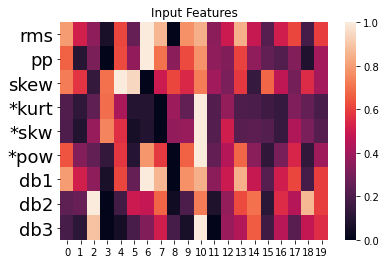

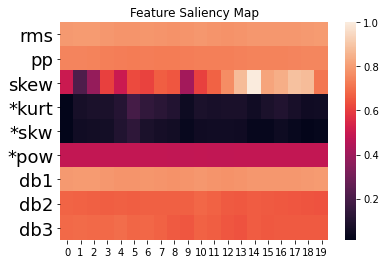

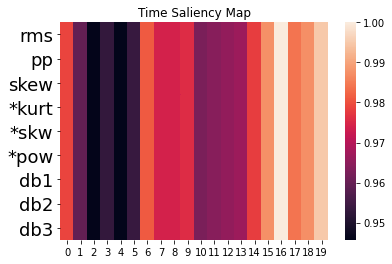

In [ ]:
idx = indices[0]
print(labels_list[y_trainonehot[idx]])
normal_fea = min_max_scaler.fit_transform(X_trainnew[idx,:,:,0])
ax = sns.heatmap(normal_fea.T, yticklabels=YTicks)
ax.tick_params(axis="y", labelsize=18)
plt.title("Input Features")
plt.show()
plt.close()

camnew = compute_cam(model, X_trainnew[idx:idx+1], y_trainonehot[idx], "feaconv")
ax = sns.heatmap(camnew.T, yticklabels=YTicks)
ax.tick_params(axis="y", labelsize=18)
plt.title("Feature Saliency Map")
plt.show()
plt.close()
camnew = compute_cam(model, X_trainnew[idx:idx+1], y_trainonehot[idx] ,"timeconv")
ax = sns.heatmap(camnew.T, yticklabels=YTicks)
ax.tick_params(axis="y", labelsize=18)
plt.title("Time Saliency Map")
plt.show()
plt.close()

#### Inner 

In [ ]:
indices = [i for i, x in enumerate(y_trainonehot) if x == 1]
random.shuffle(indices)

inner


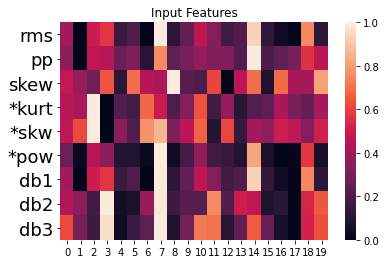

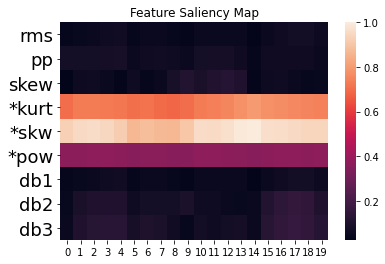

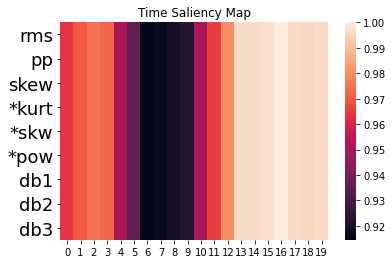

In [ ]:
idx = indices[0]
print(labels_list[y_trainonehot[idx]])
normal_fea = min_max_scaler.fit_transform(X_trainnew[idx,:,:,0])
ax = sns.heatmap(normal_fea.T, yticklabels=YTicks)
ax.tick_params(axis="y", labelsize=18)
plt.title("Input Features")
plt.show()
plt.close()

camnew = compute_cam(model, X_trainnew[idx:idx+1], y_trainonehot[idx], "feaconv")
ax = sns.heatmap(camnew.T, yticklabels=YTicks)
ax.tick_params(axis="y", labelsize=18)
plt.title("Feature Saliency Map")
plt.show()
plt.close()
camnew = compute_cam(model, X_trainnew[idx:idx+1], y_trainonehot[idx] ,"timeconv")
ax = sns.heatmap(camnew.T, yticklabels=YTicks)
ax.tick_params(axis="y", labelsize=18)
plt.title("Time Saliency Map")
plt.show()
plt.close()

#### Ball

In [ ]:
indices = [i for i, x in enumerate(y_trainonehot) if x == 2]
random.shuffle(indices)

ball


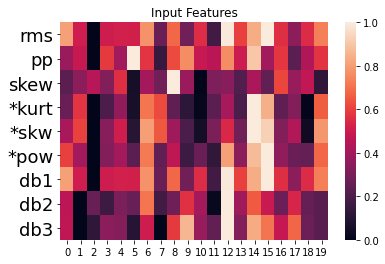

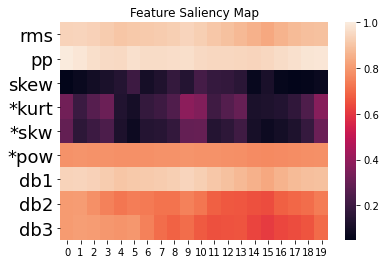

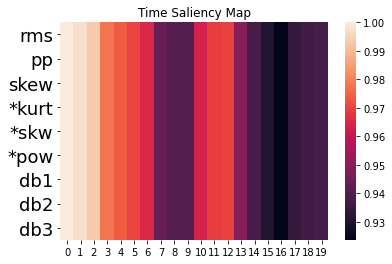

In [ ]:
idx = indices[0]
print(labels_list[y_trainonehot[idx]])
normal_fea = min_max_scaler.fit_transform(X_trainnew[idx,:,:,0])
ax = sns.heatmap(normal_fea.T, yticklabels=YTicks)
ax.tick_params(axis="y", labelsize=18)
plt.title("Input Features")
plt.show()
plt.close()

camnew = compute_cam(model, X_trainnew[idx:idx+1], y_trainonehot[idx], "feaconv")
ax = sns.heatmap(camnew.T, yticklabels=YTicks)
ax.tick_params(axis="y", labelsize=18)
plt.title("Feature Saliency Map")
plt.show()
plt.close()
camnew = compute_cam(model, X_trainnew[idx:idx+1], y_trainonehot[idx] ,"timeconv")
ax = sns.heatmap(camnew.T, yticklabels=YTicks)
ax.tick_params(axis="y", labelsize=18)
plt.title("Time Saliency Map")
plt.show()
plt.close()

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

#### Outer Fault

In [ ]:
indices = [i for i, x in enumerate(y_trainonehot) if x == 3]
random.shuffle(indices)

outer


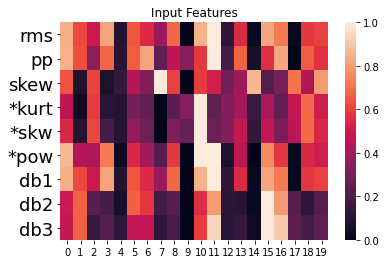

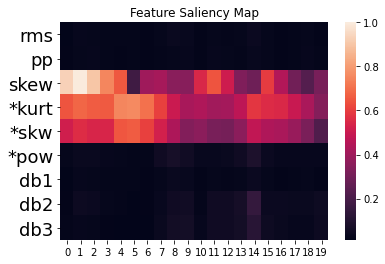

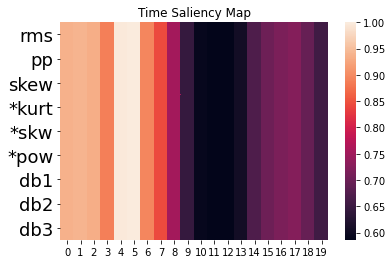

In [ ]:
idx = indices[0]
print(labels_list[y_trainonehot[idx]])
nnormal_fea = min_max_scaler.fit_transform(X_trainnew[idx,:,:,0])
ax = sns.heatmap(normal_fea.T, yticklabels=YTicks)
ax.tick_params(axis="y", labelsize=18)
plt.title("Input Features")
plt.show()
plt.close()

camnew = compute_cam(model, X_trainnew[idx:idx+1], y_trainonehot[idx], "feaconv")
ax = sns.heatmap(camnew.T, yticklabels=YTicks)
ax.tick_params(axis="y", labelsize=18)
plt.title("Feature Saliency Map")
plt.show()
plt.close()
camnew = compute_cam(model, X_trainnew[idx:idx+1], y_trainonehot[idx] ,"timeconv")
ax = sns.heatmap(camnew.T, yticklabels=YTicks)
ax.tick_params(axis="y", labelsize=18)
plt.title("Time Saliency Map")
plt.show()
plt.close()